In [8]:
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sympy.solvers import solve
from sympy import Symbol
import scipy.stats as sstats

from os import path

from scripts.utils import SimulateData
from stopsignalmetrics import SSRTmodel, StopData

from scipy.stats import exponnorm, norm, norminvgauss
from scipy import stats

from batch_files.generate_remaining_sim_cmds import replace

In [9]:
OVERWRITE_MUS = False

# __Preprocessing__

## 1. Prepare data for use by stopsignalmetrics

In [3]:
abcd_data = pd.read_csv('abcd_data/abcd_w_finger_press.csv')

In [4]:
len(abcd_data.NARGUID.unique())

8464

In [5]:
for rt_col in ['go_rt_adjusted', 'stop_rt_adjusted']:
    abcd_data.loc[abcd_data['finger_press'].isnull(), rt_col] = np.nan

In [6]:
abcd_data['block'] = np.NaN
abcd_data.loc[abcd_data['TrialNum'] < 180, 'block'] = '1'
abcd_data.loc[abcd_data['TrialNum'] >= 180, 'block'] = '2'

In [7]:
abcd_data['choice_accuracy'] = np.where(
    abcd_data['finger_press'].notnull(),
    np.where(
        abcd_data['finger_press']==abcd_data['correct_response'],
        1,
        0),
    np.nan
)

In [8]:
len(abcd_data.NARGUID.unique())

8464

## 1.5 replace IDs with ` (backticks) in them
#### shell scripts do not interpret them well

In [9]:
def strip_backticks(string):
    return string.replace('`', '')

In [10]:
original_unique_IDs = abcd_data.NARGUID.unique()
fix_id_map = {i:strip_backticks(i) for i in abcd_data.NARGUID.unique() if '`' in i}
abcd_data.NARGUID = abcd_data.NARGUID.replace(fix_id_map)
assert len(original_unique_IDs)==len(abcd_data.NARGUID.unique())

In [11]:
abcd_data.to_csv('abcd_data/minimal_abcd_with_issue_3.csv', index=False)

## 2. Drop Issue 3 people

In [12]:
abcd_data_w_issue_3 = pd.read_csv('abcd_data/minimal_abcd_with_issue_3.csv')

In [13]:
abcd_data_w_issue_3['correct_go_response'].unique()

array([ 1.,  0., nan])

In [14]:
issue_3_people = abcd_data_w_issue_3.loc[(abcd_data_w_issue_3['stop_rt_adjusted'] < 50) & (abcd_data_w_issue_3['stop_rt_adjusted'] > 0) & (abcd_data_w_issue_3['SSDDur'] ==50), 'NARGUID'].unique()

print('n affected:', len(issue_3_people))
print('p affect:', len(issue_3_people)/ 7231)

abcd_data = abcd_data_w_issue_3[~abcd_data_w_issue_3.NARGUID.isin(issue_3_people)].copy()
print('n remaining:', abcd_data.NARGUID.nunique())

n affected: 226
p affect: 0.03125432167058498
n remaining: 8238


In [15]:
abcd_data.to_csv('abcd_data/minimal_abcd_clean.csv', index=False)

# __Metrics for Simulation__

In [3]:
abcd_data = pd.read_csv('abcd_data/minimal_abcd_clean.csv')

## 1. get a distribution of mean go RTs and SSRTs to sample from

In [4]:
variable_dict = {
   "columns": {
      "ID": "NARGUID", #subject identifier
      "condition": "trial_type", #col with trial types 
      "correct_response": "correct_response", #col with correct reponse codes
      "response": "finger_press", #col with actual response codes 
      "SSD": "SSDDur", #col with stop signal delay 
      "block": "block", #col with which block a trial is accuring during
      "goRT": "go_rt_adjusted", # col with go reaction time recording 
      "stopRT": "stop_rt_adjusted", #col with stop failure reaction time recording
      "choice_accuracy": "choice_accuracy" #col with whether a response was correct
   },
   "key_codes": {
      "go": "GoTrial", # cell values for go trials  
      "stop": "StopTrial",  #cell values for stop trials 
      "correct": 1.0,
       "incorrect": 0.0,
       "noResponse": np.nan
   }
}

In [5]:
abcd_ssrt = StopData(var_dict=variable_dict, compute_acc_col=False)

abcd_proc = abcd_ssrt.fit_transform(abcd_data) 

ssrt_model = SSRTmodel(model='replacement')

ssrt_metrics = ssrt_model.fit_transform(abcd_proc, level='group')

problem_subs = ssrt_metrics[ssrt_metrics.SSRT.isnull()].index

print(f'dropping {len(problem_subs)} subs for having P(respond|signal) == 1 or 0')

ssrt_metrics = ssrt_metrics[ssrt_metrics.SSRT.notnull()].copy()

dropping 31 subs for having P(respond|signal) == 1 or 0


In [13]:
ssrt_metrics.to_csv('abcd_data/abcd_ssrt_metrics.csv')

In [9]:
# def get_mus(sub_row):
#     sub_row = sub_row.copy()
#     mu_dict = {}
#     # init go and stop vars
#     g = Symbol('g')
#     s = Symbol('s')
    
#     # formulas (must be solved as "expression = 0")
#     # subject_{go/ss}rt = threshold/mu_go + nondecision_time
#     # threshold = 100
#     # nondecision_time = 50
    
#     go_sol = solve((sub_row['mean_go_RT'].values[0] - 50) * g - 100, g)
# #     go_sol = solve(100/g + 50 - sub_row['mean_go_RT'].values[0], g)
#     assert len(go_sol) == 1, f"{len(go_sol)} solutions found based on {sub_row['mean_go_RT']}: {go_sol}"
#     mu_dict['go'] = float(go_sol[0])
    
#     stop_sol = solve(100/s + 50 - sub_row['SSRT'].values[0], s)
#     assert len(stop_sol) == 1, f"{len(stop_sol)} solutions found based on {sub_row['SSRT']}: {stop_sol}"
#     mu_dict['stop'] = float(stop_sol[0])
    
#     return mu_dict

# mu_df = ssrt_metrics.groupby('ID').apply(get_mus)
# mu_dict = mu_df.to_dict()
# mu_dict['prob_subs'] = list(problem_subs)
# mu_df = mu_df.apply(pd.Series)

# json_mu_path = 'abcd_data/individual_mus.json'
# with open(json_mu_path, 'w') as jp:
#     json.dump(mu_dict, jp)

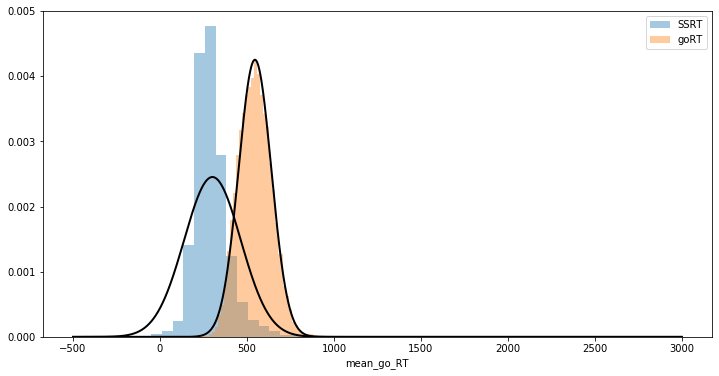

In [10]:
fig = plt.figure(figsize=(12,6))
ax = sns.distplot(ssrt_metrics['SSRT'], kde=False, norm_hist=True, label='SSRT')
ssrt_loc,ssrt_var = norm.fit(ssrt_metrics['SSRT'])
xx = np.arange(-500, 3000, 1)
ax.plot(xx, norm.pdf(xx, loc=ssrt_loc, scale=ssrt_var), 'k', lw=2)  
_ = sns.distplot(ssrt_metrics['mean_go_RT'], kde=False,norm_hist=True, ax=ax, label='goRT')
goRT_loc,goRT_var = norm.fit(ssrt_metrics['mean_go_RT'])
ax.plot(xx, norm.pdf(xx, loc=goRT_loc, scale=goRT_var), 'k', lw=2) 
_ = plt.legend()

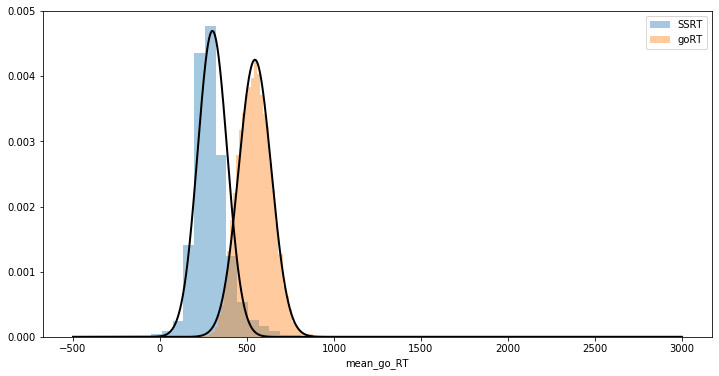

In [11]:
# repeating but giving a reasonable scale for the SSRT distribution

fig = plt.figure(figsize=(12,6))
ax = sns.distplot(ssrt_metrics['SSRT'], kde=False, norm_hist=True, label='SSRT')
xx = np.arange(-500, 3000, 1)
ax.plot(xx, norm.pdf(xx, loc=ssrt_loc, scale=85), 'k', lw=2)  
_ = sns.distplot(ssrt_metrics['mean_go_RT'], kde=False,norm_hist=True, ax=ax, label='goRT')
ax.plot(xx, norm.pdf(xx, loc=goRT_loc, scale=goRT_var), 'k', lw=2) 
_ = plt.legend()

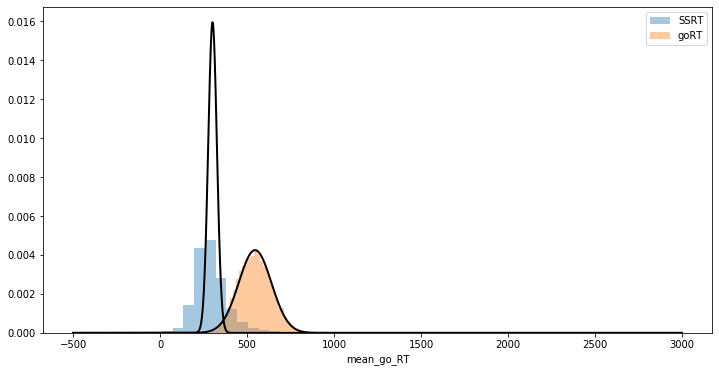

In [12]:
fig = plt.figure(figsize=(12,6))
ax = sns.distplot(ssrt_metrics['SSRT'], kde=False, norm_hist=True, label='SSRT')
xx = np.arange(-500, 3000, 1)
ax.plot(xx, norm.pdf(xx, loc=ssrt_loc, scale=25), 'k', lw=2)  
_ = sns.distplot(ssrt_metrics['mean_go_RT'], kde=False,norm_hist=True, ax=ax, label='goRT')
ax.plot(xx, norm.pdf(xx, loc=goRT_loc, scale=goRT_var), 'k', lw=2) 
_ = plt.legend()

## 1. get SSD distributions per subject

In [10]:
MAX_SSD = 500 #for clipping distributions

In [11]:
abcd_data = pd.read_csv('abcd_data/minimal_abcd_clean.csv')

In [12]:
SSD_dist = abcd_data.groupby('NARGUID')['SSDDur'].value_counts(normalize=True)
SSD_dist.name = 'proportion'
SSD_dist = SSD_dist.reset_index()
SSD_dist.to_csv(f'abcd_data/SSD_dist_by_subj_{MAX_SSD}Clip-False.csv', index=False)

In [13]:
SSD_dist_clipped = abcd_data.query(f"(SSDDur <= {MAX_SSD}) | (trial_type=='GoTrial')").groupby('NARGUID')['SSDDur'].value_counts(normalize=True)
SSD_dist_clipped.name = 'proportion'
SSD_dist_clipped = SSD_dist_clipped.reset_index()
SSD_dist_clipped.to_csv(f'abcd_data/SSD_dist_by_subj_{MAX_SSD}Clip-True.csv', index=False)

In [14]:
len(SSD_dist.query(f"SSDDur > {MAX_SSD}").NARGUID.unique())

1892

In [18]:
SSD_dist_clipped.query("NARGUID == '00LJVZK2'")

,NARGUID,SSDDur,proportion
38,00LJVZK2,0.0,0.188679
39,00LJVZK2,50.0,0.132075
40,00LJVZK2,100.0,0.113208
41,00LJVZK2,150.0,0.094340
42,00LJVZK2,350.0,0.094340
43,00LJVZK2,200.0,0.075472
44,00LJVZK2,300.0,0.075472
45,00LJVZK2,400.0,0.075472
46,00LJVZK2,250.0,0.056604
47,00LJVZK2,450.0,0.056604


# 1.5 Sample Mus if necessary

assigning mus


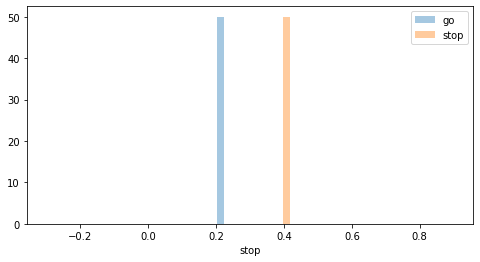

In [31]:
SSRT_SCALE = 0  # 85
GORT_SCALE = 0 # goRT_var


def convert_to_mu(rt, thresh=100, ndt=50):
    # example solve:
    # Threshold = mu * (rt - non-decision-time)
    # Threshold / (rt - ndt) = mu
    return thresh/(rt-ndt)

def sample(mean, scale, ndt=50):
    tmp = np.random.normal(loc=mean, scale=scale)
    # if it is less that the non-decision-time, you get negative mus
    # if it is close to the nondecision time, you get HUGE mus
    while tmp < ndt+10: 
        tmp = np.random.normal(loc=mean, scale=scale)
    return tmp

write_out_path = 'abcd_data/assigned_mus.json'
if not path.exists(write_out_path) or OVERWRITE_MUS:
    print('assigning mus')
    mus_dict = {}
    for sub in SSD_dist.NARGUID.unique():
        mus_dict[sub] = {}
        mus_dict[sub]['goRT'] = sample(mean=goRT_loc, scale=GORT_SCALE)
        mus_dict[sub]['go'] = convert_to_mu(mus_dict[sub]['goRT'])
        mus_dict[sub]['SSRT'] = sample(mean=ssrt_loc, scale=SSRT_SCALE)
        mus_dict[sub]['stop'] = convert_to_mu(mus_dict[sub]['SSRT']) 
    with open(write_out_path, 'w') as jp:
        json.dump(mus_dict, jp)    
            
    # visualize
    mu_df = pd.DataFrame(mus_dict).T
    fig = plt.figure(figsize=(8,4))
    ax = sns.distplot(mu_df['go'], kde=False, norm_hist=True, label='go')
    _ = sns.distplot(mu_df['stop'], kde=False,norm_hist=True, ax=ax, label='stop')
    _ = plt.legend()

In [7]:
SSD_dist.NARGUID.unique()

NameError: name 'SSD_dist' is not defined

# Exgauss metrics

In [30]:
abcd_data = pd.read_csv('abcd_data/minimal_abcd_clean.csv')
SSD0_RTs = abcd_data.query(
    "SSDDur == 0.0 and correct_stop==0.0"
    ).stop_rt_adjusted.values

FIT_K, FIT_LOC, FIT_SCALE = sstats.exponnorm.fit(SSD0_RTs)
FIT_LAMBDA = 1/(FIT_K*FIT_SCALE)
FIT_BETA = 1/FIT_LAMBDA

In [31]:
exgaus_params = {
    'K': FIT_K,
    'loc': FIT_LOC,
    'scale': FIT_SCALE,
    'lambda': FIT_LAMBDA,
    'beta': FIT_BETA,
}

with open('abcd_data/exgauss_params.json', 'w') as f:
    json.dump(exgaus_params, f)

## 2. P(guess|SSD) for mixture distributions

In [19]:
abcd_data = pd.read_csv('abcd_data/minimal_abcd_clean.csv')
SSDs = abcd_data.SSDDur.unique()
SSDs = [i for i in SSDs if i == i]
SSDs.sort()

In [20]:
acc_per_SSD = pd.DataFrame()
for ssd in SSDs:
    curr_means = abcd_data.query(
        "SSDDur == %s and correct_stop==0.0" % ssd
    ).groupby('NARGUID').mean()['choice_accuracy']
    curr_means.name = ssd
    acc_per_SSD = pd.concat([acc_per_SSD, curr_means], 1, sort=True)

go_accs = abcd_data.query(
        "trial_type == 'GoTrial' and correct_go_response in [1.0, 0.0]"
    ).groupby('NARGUID').mean()['choice_accuracy']
go_accs.name = -1
acc_per_SSD = pd.concat([acc_per_SSD, go_accs], 1, sort=True)

In [22]:
acc_per_SSD.describe()

,0.0,50.0,100.0,150.0,200.0,250.0,300.0,350.0,400.0,450.0,500.0,550.0,600.0,650.0,700.0,750.0,800.0,850.0,900.0,-1.0
count,2944.000000,4146.000000,4819.000000,5759.000000,6554.000000,6817.000000,6566.000000,5842.000000,4783.000000,3651.000000,2516.000000,1661.000000,1057.000000,630.000000,392.000000,239.000000,138.000000,117.000000,115.000000,8210.000000
mean,0.499410,0.561566,0.656870,0.723856,0.795379,0.830639,0.860157,0.884024,0.895152,0.906854,0.912347,0.919252,0.917789,0.914306,0.894193,0.904812,0.852174,0.831197,0.817350,0.919088
std,0.309872,0.346036,0.328498,0.303200,0.263413,0.243262,0.230942,0.219983,0.223044,0.218917,0.224541,0.229288,0.229932,0.240663,0.276771,0.263033,0.319575,0.327071,0.333918,0.085973
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.333333,0.333333,0.500000,0.500000,0.666667,0.750000,0.800000,0.833333,0.875000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.833333,0.666667,0.898613
50%,0.500000,0.571429,0.666667,0.800000,0.875000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.941708
75%,0.666667,0.880515,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.969900
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [34]:
acc_per_SSD.mean()

 0.0      0.499410
 50.0     0.561566
 100.0    0.656870
 150.0    0.723856
 200.0    0.795379
 250.0    0.830639
 300.0    0.860157
 350.0    0.884024
 400.0    0.895152
 450.0    0.906854
 500.0    0.912347
 550.0    0.919252
 600.0    0.917789
 650.0    0.914306
 700.0    0.894193
 750.0    0.904812
 800.0    0.852174
 850.0    0.831197
 900.0    0.817350
-1.0      0.919088
dtype: float64

In [35]:
p = Symbol('p')
guess_mean = acc_per_SSD.mean()[0.0]
go_mean = acc_per_SSD.mean()[-1]
p_guess_per_SSD = {}
for ssd in SSDs:
    curr_mean = acc_per_SSD.mean()[ssd]
    solution = solve(p*guess_mean + (1-p)*go_mean - curr_mean, p)
    assert len(solution) == 1
    p_guess_per_SSD[ssd] = solution[0]
p_guess_df = pd.DataFrame(p_guess_per_SSD, index=['p_guess'])
p_guess_df.to_csv('abcd_data/p_guess_per_ssd.csv', index=False)

In [36]:
{col: float(p_guess_df[col].values[0]) for col
                      in p_guess_df.columns}

{0.0: 1.0,
 50.0: 0.8518966881510508,
 100.0: 0.6248081425758761,
 150.0: 0.46519470731379453,
 200.0: 0.2947710624963631,
 250.0: 0.21075535798552303,
 300.0: 0.1404209047269027,
 350.0: 0.08354920017624702,
 400.0: 0.05703409119007931,
 450.0: 0.029151024358994575,
 500.0: 0.016063618909064378,
 550.0: -0.0003910068585019575,
 600.0: 0.0030962512655911116,
 650.0: 0.01139533818314855,
 700.0: 0.059318925632538,
 750.0: 0.0340178091093458,
 800.0: 0.15944204679687593,
 850.0: 0.20942638758940402,
 900.0: 0.24241997384504005}

In [37]:
p_guess_df2 = pd.read_csv('abcd_data/p_guess_per_ssd.csv')

In [38]:
p_guess_df2

,0.0,50.0,100.0,150.0,200.0,250.0,300.0,350.0,400.0,450.0,500.0,550.0,600.0,650.0,700.0,750.0,800.0,850.0,900.0
0,1.0,0.851897,0.624808,0.465195,0.294771,0.210755,0.140421,0.083549,0.057034,0.029151,0.016064,-0.000391,0.003096,0.011395,0.059319,0.034018,0.159442,0.209426,0.24242


## Within subjects SD of RTs for stop-fail and go RTs

In [27]:
abcd_data.describe()

,go_rt_adjusted,stop_rt_adjusted,SSDDur,correct_go_response,correct_stop,SSD.RESP,Fix.RESP,StopSignal.RESP,Go.RESP,TrialNum,correct_stimulus_mapping_1,correct_stimulus_mapping_2,block,finger_press,correct_response,choice_accuracy
count,2.292144e+06,238026.000000,494283.000000,2.471397e+06,494283.000000,19624.000000,236334.000000,171150.000000,2.203096e+06,2.965680e+06,2965680.0,2965680.0,2.965680e+06,2.530170e+06,2965680.0,2.530170e+06
mean,5.437762e+02,458.165058,236.154895,8.411251e-01,0.518442,1.591215,1.638694,1.602530,1.603930e+00,1.805000e+02,1.5,3.5,1.502778e+00,1.493806e+00,1.5,9.096041e-01
std,2.135862e+02,207.786635,159.296667,3.655595e-01,0.499660,0.662964,0.685852,0.682406,6.827720e-01,1.039227e+02,0.5,0.5,4.999924e-01,4.999617e-01,0.5,2.867482e-01
min,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,1.000000,1.000000,1.000000,1.000000e+00,1.000000e+00,1.0,3.0,1.000000e+00,1.000000e+00,1.0,0.000000e+00
25%,3.990000e+02,336.000000,100.000000,1.000000e+00,0.000000,1.000000,1.000000,1.000000,1.000000e+00,9.075000e+01,1.0,3.0,1.000000e+00,1.000000e+00,1.0,1.000000e+00
50%,5.060000e+02,426.000000,200.000000,1.000000e+00,1.000000,2.000000,2.000000,2.000000,2.000000e+00,1.805000e+02,1.5,3.5,2.000000e+00,1.000000e+00,1.5,1.000000e+00
75%,6.460000e+02,530.000000,350.000000,1.000000e+00,1.000000,2.000000,2.000000,2.000000,2.000000e+00,2.702500e+02,2.0,4.0,2.000000e+00,2.000000e+00,2.0,1.000000e+00
max,2.793000e+03,2835.000000,900.000000,1.000000e+00,1.000000,4.000000,4.000000,4.000000,4.000000e+00,3.600000e+02,2.0,4.0,2.000000e+00,2.000000e+00,2.0,1.000000e+00


In [23]:
abcd_data = pd.read_csv('abcd_data/minimal_abcd_clean.csv')


In [29]:
abcd_data[['NARGUID', 'go_rt_adjusted', 'stop_rt_adjusted']].groupby('NARGUID').apply(lambda x: x.describe().loc['std', :]).mean()

std
go_rt_adjusted      190.272261
stop_rt_adjusted    155.122888
dtype: float64

In [30]:
rt_desc = abcd_data[['NARGUID', 'go_rt_adjusted', 'stop_rt_adjusted']].groupby('NARGUID').describe()
rt_desc

go_rt_adjusted                                                        \
                  count        mean         std    min     25%    50%     75%   
NARGUID                                                                         
003RTV85          285.0  634.652632  169.271353  333.0  515.00  595.0  728.00   
007W6H7B          297.0  653.491582  178.164613  318.0  515.00  609.0  764.00   
00CY2MDM          284.0  467.901408  200.308095    4.0  331.00  414.0  566.25   
00HEV6HB          289.0  450.200692  228.866837    6.0  313.00  440.0  527.00   
00J52GPG          281.0  405.978648  157.648749  104.0  284.00  350.0  494.00   
...                 ...         ...         ...    ...     ...    ...     ...   
vcahyykd            0.0         NaN         NaN    NaN     NaN    NaN     NaN   
ve4u5             283.0  451.784452  132.458823  196.0  367.00  432.0  515.50   
wzrf2ge6          275.0  591.981818  186.033696  311.0  469.50  547.0  658.00   
x8k59             289.0  488.622837  143.985096  210.0  380.00  478.0  565.00   
xxmy9wd8          252.0  535.813492  242.239257   39.0  355.25  483.0  660.75   

                 stop_rt_adjusted                                         \
             max            count        mean         std    min     25%   
NARGUID                                                                    
003RTV85  1336.0             28.0  546.107143   96.794681  395.0  496.25   
007W6H7B  1242.0             26.0  562.000000  121.130673  405.0  474.75   
00CY2MDM  1332.0             36.0  347.583333   92.117743  116.0  272.50   
00HEV6HB  1688.0             38.0  373.947368  289.887298   83.0  256.00   
00J52GPG  1165.0             36.0  305.194444   67.751993  245.0  265.00   
...          ...              ...         ...         ...    ...     ...   
vcahyykd     NaN              0.0         NaN         NaN    NaN     NaN   
ve4u5     1053.0             27.0  387.851852  101.128518  264.0  303.00   
wzrf2ge6  1520.0             27.0  502.111111  102.445232  247.0  429.50   
x8k59     1081.0             28.0  385.892857   87.299119  239.0  321.00   
xxmy9wd8  1653.0             32.0  382.218750  122.849694  126.0  314.75   

                                 
            50%     75%     max  
NARGUID                          
003RTV85  525.0  564.25   877.0  
007W6H7B  541.5  645.25   859.0  
00CY2MDM  349.0  405.50   530.0  
00HEV6HB  343.5  403.00  1884.0  
00J52GPG  285.5  319.25   543.0  
...         ...     ...     ...  
vcahyykd    NaN     NaN     NaN  
ve4u5     370.0  443.50   595.0  
wzrf2ge6  481.0  573.00   692.0  
x8k59     369.5  460.75   561.0  
xxmy9wd8  356.5  450.25   776.0  

[8238 rows x 16 columns]

In [ ]:
rt_desc

## 3. Inhibition function (p(respond|SSD))

In [33]:
def get_p_resp_per_SSD(data, SSDs):
    data = data.copy()
    out_dict = {}
    for ssd in SSDs:
        curr_data = data.query(
            "SSDDur == %s" % ssd
        )
        if len(curr_data) == 0:
            out_dict[ssd] = np.nan
        else:
            out_dict[ssd] = len(curr_data.query("correct_stop == 0.0")) / len(curr_data)
    return out_dict

In [34]:
abcd_data = pd.read_csv('abcd_data/minimal_abcd_clean.csv')
SSDs = [i for i in abcd_data.SSDDur.unique() if i==i]
ssd_resp_dict = abcd_data.groupby('NARGUID').apply(get_p_resp_per_SSD, SSDs)
ssd_resp_df = ssd_resp_dict.apply(pd.Series)

In [35]:
ssd_resp_df

,50.0,100.0,150.0,0.0,200.0,250.0,300.0,350.0,400.0,450.0,500.0,550.0,600.0,650.0,700.0,750.0,800.0,850.0,900.0
NARGUID,,,,,,,,,,,,,,,,,,,
003RTV85,0.000000,0.000000,0.000000,NaN,0.333333,0.090909,0.666667,0.500000,0.454545,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
007W6H7B,0.000000,0.000000,0.250000,NaN,0.666667,0.000000,0.666667,0.000000,0.250000,0.2,0.571429,0.75,0.666667,0.5,1.0,NaN,NaN,NaN,NaN
00CY2MDM,0.375000,0.625000,0.666667,0.687500,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00HEV6HB,0.666667,0.500000,0.250000,0.888889,0.500000,0.250000,0.750000,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00J52GPG,0.631579,0.700000,0.750000,0.500000,0.500000,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
vcahyykd,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.00,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
ve4u5,0.200000,0.500000,0.181818,0.000000,0.444444,0.692308,0.750000,0.000000,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
wzrf2ge6,0.000000,0.000000,0.000000,NaN,0.000000,0.272727,0.411765,0.600000,0.750000,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [41]:
ssd_resp_melt = ssd_resp_df.reset_index().melt(id_vars='NARGUID', value_vars=ssd_resp_df.columns, var_name='SSD', value_name='p_respond' )
ssd_resp_melt['underlying distribution'] = 'ABCD data'
ssd_resp_melt.to_csv('abcd_data/abcd_inhib_func_per_sub.csv', index=False)

In [42]:
abcd_inhib_func = pd.DataFrame(ssd_resp_df.mean())
abcd_inhib_func.index.name = 'SSD'
abcd_inhib_func.columns = ['p_respond']
abcd_inhib_func = abcd_inhib_func.reset_index()
abcd_inhib_func['underlying distribution'] = 'ABCD data'

In [43]:
abcd_inhib_func.to_csv('abcd_data/abcd_inhib_func.csv', index=False)

## 4. build run_sims.sh

In [44]:
abcd_data = pd.read_csv('abcd_data/minimal_abcd_clean.csv')

In [45]:
narguids = abcd_data.NARGUID.unique()

In [48]:
nsubs_per_job = 48
njobs_per_node = 36
nlines = 0
with open('batch_files/TACC/run_sims.sh', 'w') as f:
    for start_idx in range(0, len(narguids), nsubs_per_job):
        end_idx = start_idx + nsubs_per_job
        if end_idx > len(narguids):
            end_idx = len(narguids)
        substr = ' '.join(narguids[start_idx:end_idx])
        f.write(f'python simulate_individuals.py --subjects {substr}\n')
        nlines += 1
nlines

172

In [50]:
N_line_str = '#SBATCH -N %d # number of nodes requested - set to ceil(n rows in command script / 36)\n' % int(np.ceil(nlines/njobs_per_node))
n_line_str = '#SBATCH -n %s # total number of mpi tasks requested - set to n rows in command script\n' % nlines

replace(
    'batch_files/TACC/launch_sim_cmds.slurm',
    '#SBATCH -N',
    N_line_str)
replace(
    'batch_files/TACC/launch_sim_cmds.slurm',
    '#SBATCH -n',
    n_line_str)
# prints so you can compare the lines of the slurm file
print(N_line_str)
print(n_line_str)

#SBATCH -N 5 # number of nodes requested - set to ceil(n rows in command script / 36)

#SBATCH -n 172 # total number of mpi tasks requested - set to n rows in command script



In [51]:
# # Sherlock version

# sher_sim_file = 'sherlock_run_sims.batch'

# N_line_str = '#SBATCH -N %d # number of nodes requested - set to ceil(n rows in command script / 36)\n' % int(np.ceil(nlines/njobs_per_node))
# n_line_str = '#SBATCH -n %s # total number of mpi tasks requested - set to n rows in command script\n' % nlines

# replace(
#     sher_sim_file,
#     '#SBATCH -N',
#     N_line_str)
# replace(
#     sher_sim_file,
#     '#SBATCH -n',
#     n_line_str)

In [60]:
sher_sim_file = 'batch_files/sherlock/sherlock_run_sims%d.batch'

ABCD_LOC = '/oak/stanford/groups/russpold/users/henrymj/ABCD_simulations/abcd_data'
OUT_LOC = '/oak/stanford/groups/russpold/users/henrymj/ABCD_simulations/simulated_data/individual_data'

sher_header = '''#!/bin/bash
#SBATCH --job-name=sims
#SBATCH --output=.out/sims%d.out
#SBATCH --error=.err/sims%d.err
#SBATCH --time=3:00:00
#SBATCH --mail-type=END
#SBATCH --mail-user=henrymj@stanford.edu
#SBATCH -N 1 # number of nodes requested - set to ceil(n rows in command script / 24)
#SBATCH -n %d # total number of mpi tasks requested - set to n rows in command script
#SBATCH -p russpold,normal
# Job Submission
#-----------
export PYTHONPATH=""

source ~/miniconda3/etc/profile.d/conda.sh 
conda activate py3-env

'''

In [62]:
nsubs_per_job = 48
njobs_per_node = 24
nlines = 0
batch_counter = 0

file_str = sher_header
for start_idx in range(0, len(narguids), nsubs_per_job):
    end_idx = start_idx + nsubs_per_job
    if end_idx > len(narguids):
        end_idx = len(narguids)
    substr = ' '.join(narguids[start_idx:end_idx])
    file_str += (f'eval "python ../../scripts/simulate_individuals.py --abcd_dir {ABCD_LOC} --out_dir {OUT_LOC} --subjects {substr}" &\n')
    nlines += 1
    if nlines == 24:
        with open(sher_sim_file % batch_counter, 'w') as f:
            f.write(file_str % (batch_counter, batch_counter, nlines))
            f.write(f'wait\n')
        # reset for new batch file
        file_str = sher_header
        nlines = 0
        batch_counter += 1
# at end, if things didn't split out evenly, write out the remaining subs
if nlines > 0:
    with open(sher_sim_file % batch_counter, 'w') as f:
        f.write(file_str % (batch_counter, batch_counter, nlines))
        f.write(f'wait\n')


In [ ]:
# nsubs_per_job = 48
# njobs_per_node = 24
# nlines = 0
# with open(sher_sim_file, 'a') as f:
#     for start_idx in range(0, len(narguids), nsubs_per_job):
#         end_idx = start_idx + nsubs_per_job
#         if end_idx > len(narguids):
#             end_idx = len(narguids)
#         substr = ' '.join(narguids[start_idx:end_idx])
#         f.write(f'eval "python simulate_individuals.py --subjects {substr}" &\n')
#         nlines += 1
#         if nlines = 24:
#             break
#     f.write(f'wait\n')
# nlines